In [1]:
#!/bin/bash
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data
# !kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri
# !unzip "./brain-tumor-classification-mri.zip"


In [7]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor, Resize, Normalize, Compose, Grayscale
from torchvision.transforms import v2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model


In [8]:
SIZE = (100, 100)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), 
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(p = 0.5),
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_train_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def compute_test_transformations(image):
    image = test_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


/home/alf/anul4/InvatareSupervizataTema2/venv/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
def training_loop(model, criterion, optimizer, dataloader : DataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return 2 * current_training_loss / len(dataloader),  all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader : DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return 2 * current_validation_loss / len(dataloader),  all_val_preds, all_val_labels

def train_model(model, epochs, data, criterion, optimizer, lr_scheduler, early_stopping : EarlyStopping):
  training_loss = [] 
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []
  maxim_accuracy = -1
  for i in range(epochs):
      Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, data["train"])
      Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, data["validation"])
      if (not early_stopping.continue_training(model, Vloss)):
         print("Loss-ul nu a scazut de ceva vreme, a intervenit early stopping")
         break
      if (lr_scheduler != None):
        lr_scheduler.step(Vloss)
      training_loss.append(round(Tloss, 3))
      validation_loss.append(round(Vloss, 3))
      training_accuracy.append(round(accuracy_score(train_pred, train_labels), 3))
      validation_accuracy.append(round(accuracy_score(all_val_labels, all_val_preds), 3))
      if (maxim_accuracy < validation_accuracy[-1]):
        print(f"best model found at {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
        maxim_accuracy = validation_accuracy[-1]
      else:
         print(f"epoca {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion):
    _, preds, labels = validation_loop(model, criterion, dataloader)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [10]:
class Net(nn.Module):
    def __init__(self,  width : int, expansion : int):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = width
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * expansion
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * expansion
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * expansion
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width5 = self.width4 * expansion
        self.conv5 = nn.Conv2d(self.width4, self.width5, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(self.width5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width5, self.width4),
            nn.Dropout(p=0.5),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.5),
            nn.Linear(self.width3, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.maxpool4(self.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(self.relu(self.bn5(self.conv5(x))))
        return self.classification_layer(x)

model_try = Net(width=8, expansion=3)

for module in model_try.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode

In [11]:
grid_parameters = {
    "batch_size": [5, 10, 25, 50, 100],
    "epochs" : [50],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4],
    "weight_decay": [1e-3, 1e-4],
    "optimizer_patience" : [3, 4, 5],
    "lr_factor": [0.1, 0.3, 0.5, 0.7],
    "width": [8, 16],
    "expansion" : [2, 3, 4],
    "early_stopping_patience" : [10],
}


def show_plot(list1, list2, label1, label2, title):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel(label1)   
    plt.ylabel(label2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_matrix(matrix):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.show()
    
def add_info(info_data, precision, acc, recall, f1):
    info_data["precision"].append(precision)
    info_data["accuracy"].append(acc)
    info_data["recall"].append(recall)
    info_data["f1Score"].append(f1)
    return info_data


def create_cross_validation_data(data_chunks, test_data, current : int, train_transform, test_transform, batch_size):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    return {
        "train": DataLoader(ImagesMRIDataset(training_data, transformations=train_transform), batch_size=batch_size, shuffle=True, drop_last=True),
        "validation": DataLoader(ImagesMRIDataset(data_chunks[current], transformations=test_transform), batch_size=batch_size, shuffle=True),
        "test": DataLoader(ImagesMRIDataset(test_data, transformations=test_transform), batch_size=batch_size, shuffle=True)
    }

def compute_cross_validation(parameters, K, data_chunks, test_info, train_transforms, test_transforms, compute_functions):
    info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    for i in range(K):
        model = Net(width=parameters["width"], expansion=parameters["expansion"])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion, optimizer, lr_scheduler = compute_functions(model, parameters)
        data = create_cross_validation_data(data_chunks, test_info, i, train_transforms, test_transforms, parameters["epochs"])
        early_stopping = EarlyStopping("./aici.pth", parameters['early_stopping_patience'])
        training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, parameters["epochs"],
            data, criterion, optimizer, lr_scheduler, early_stopping)
        show_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", f"Loss model{i}")
        show_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", f"Accuracy model{i}")
        best_model = Net(width=parameters["width"], expansion=parameters["expansion"])
        early_stopping.load_model(best_model)
        precision, recall, f1, acc, mat = test_model(best_model, data["test"], criterion)
        info_test = add_info(info_test, precision, acc, recall, f1)
        return acc
    test_results = pd.DataFrame.from_dict(info_test, "columns")
    print(test_results)

best model found at 0 loss is 5.76 accuracy is 0.387
best model found at 1 loss is 2.26 accuracy is 0.732
best model found at 2 loss is 1.192 accuracy is 0.806
epoca 3 loss is 1.897 accuracy is 0.728
epoca 4 loss is 2.221 accuracy is 0.734
epoca 5 loss is 1.442 accuracy is 0.781
best model found at 6 loss is 1.142 accuracy is 0.866
best model found at 7 loss is 0.852 accuracy is 0.874
best model found at 8 loss is 0.54 accuracy is 0.904
epoca 9 loss is 6.748 accuracy is 0.609
epoca 10 loss is 0.849 accuracy is 0.896
best model found at 11 loss is 0.756 accuracy is 0.93
epoca 12 loss is 1.271 accuracy is 0.864
epoca 13 loss is 1.045 accuracy is 0.904
epoca 14 loss is 1.796 accuracy is 0.845
Loss-ul nu a scazut de ceva vreme, a intervenit early stopping


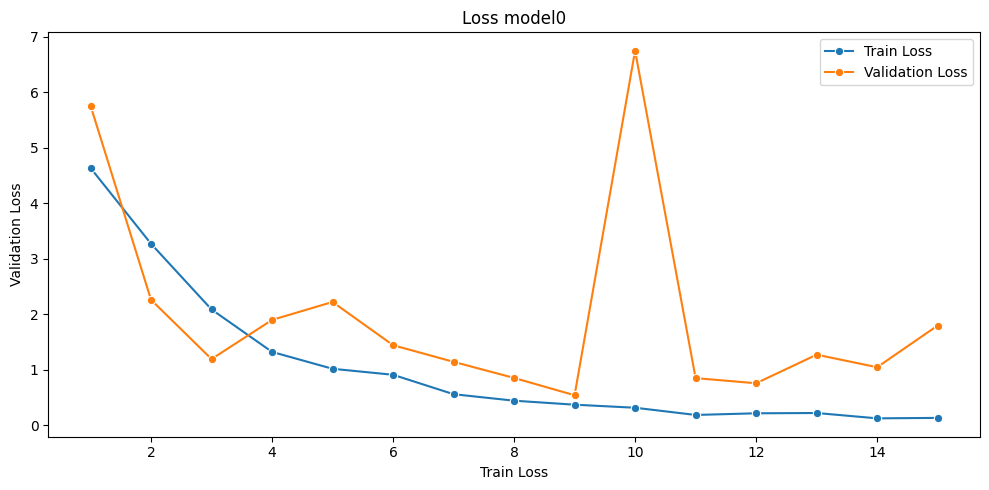

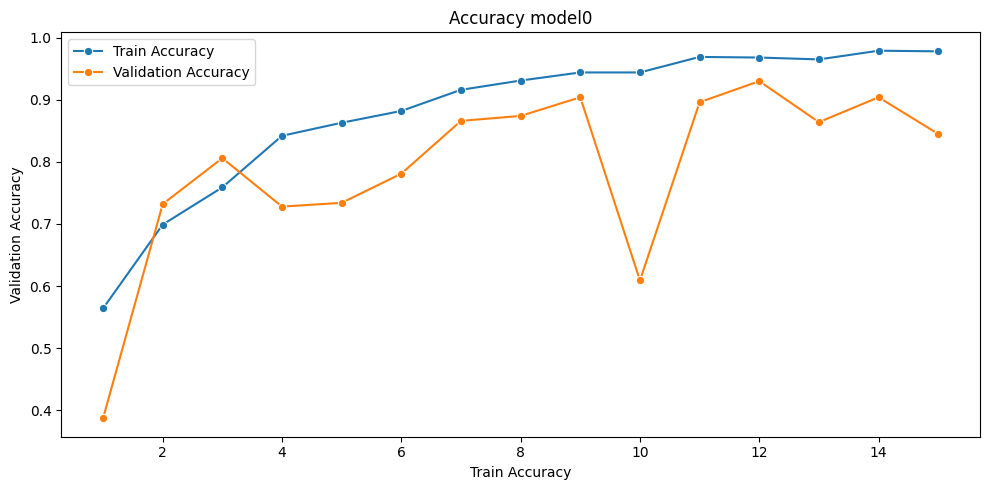

0.649746192893401

In [12]:
from collections import Counter

current_parameters = {
    "batch_size": 50,
    "epochs" : 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 4,
    "early_stopping_patience" : 7,
}
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

training_no_transforms = v2.Compose([
    ToTensor(),
    Resize(SIZE)
])

def compute_class_weights(data_stream):
    labels = [label for _, label in data_stream]
    label_counts = Counter(labels)
    total_samples = sum(label_counts.values())
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    max_label = max(label_counts.keys())
    weights_list = [class_weights.get(i, 0.0) for i in range(max_label + 1)]
    weights = torch.tensor(weights_list, dtype=torch.float)
    print(weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = weights.to(device)
    return weights 

def compute_functions_balanced_no_scheduler(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, None

 
# task 2 - fara augmentari, duplicarea exemplelor din clasele suplimentare
compute_cross_validation(current_parameters, K, data_chunks, test_info, training_no_transforms, training_no_transforms, compute_functions_balanced_no_scheduler)


best model found at 0 loss is 4.562 accuracy is 0.323
best model found at 1 loss is 3.819 accuracy is 0.46
best model found at 2 loss is 4.187 accuracy is 0.494
best model found at 3 loss is 1.898 accuracy is 0.666
epoca 4 loss is 2.369 accuracy is 0.591
epoca 5 loss is 3.133 accuracy is 0.472
best model found at 6 loss is 1.209 accuracy is 0.755
epoca 7 loss is 1.835 accuracy is 0.704
epoca 8 loss is 2.221 accuracy is 0.662
epoca 9 loss is 2.512 accuracy is 0.608
epoca 10 loss is 2.257 accuracy is 0.66
epoca 11 loss is 2.528 accuracy is 0.664
best model found at 12 loss is 0.958 accuracy is 0.809
epoca 13 loss is 1.212 accuracy is 0.764
epoca 14 loss is 1.061 accuracy is 0.806
best model found at 15 loss is 0.931 accuracy is 0.847
epoca 16 loss is 2.042 accuracy is 0.685
epoca 17 loss is 0.898 accuracy is 0.836
epoca 18 loss is 4.392 accuracy is 0.513
best model found at 19 loss is 0.616 accuracy is 0.885
epoca 20 loss is 1.547 accuracy is 0.775
epoca 21 loss is 1.082 accuracy is 0.82

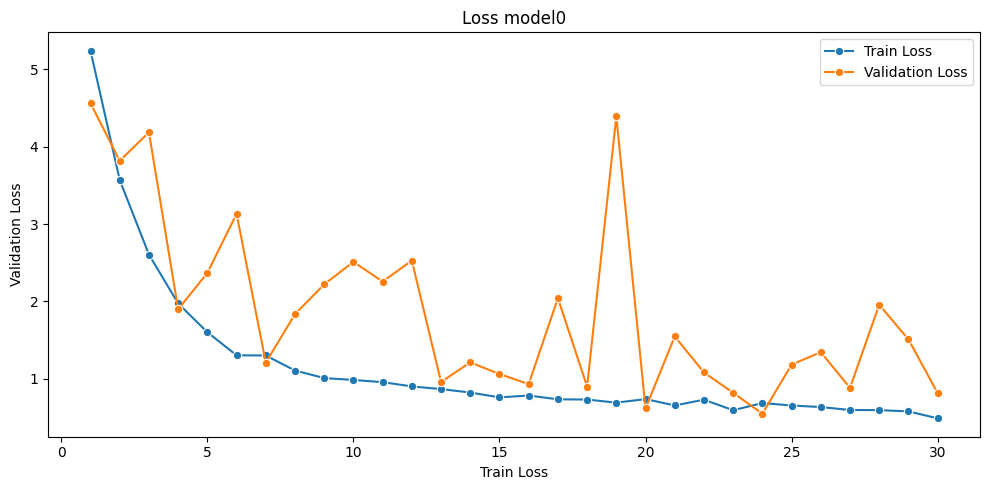

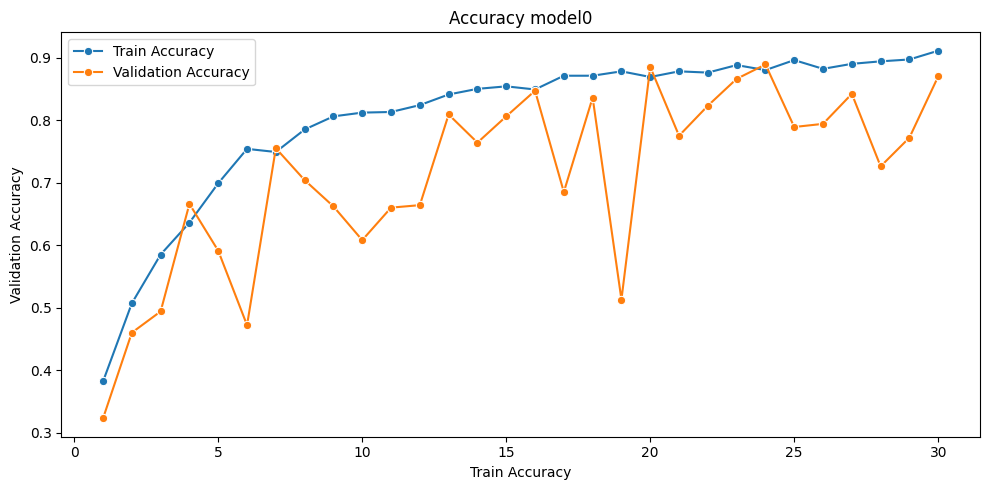

0.6903553299492385

In [13]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

# task 2 - cu augmentari, cu duplicarea exemplelor din clasele suplimentare
compute_cross_validation(current_parameters, K, data_chunks, test_info, compute_train_transformations, compute_test_transformations, compute_functions_balanced_no_scheduler)

tensor([3.4758, 3.4916, 7.2595, 3.4705])
best model found at 0 loss is 14.111 accuracy is 0.293
best model found at 1 loss is 4.688 accuracy is 0.425
best model found at 2 loss is 4.353 accuracy is 0.499
best model found at 3 loss is 2.019 accuracy is 0.612
best model found at 4 loss is 2.945 accuracy is 0.651
best model found at 5 loss is 1.376 accuracy is 0.748
epoca 6 loss is 2.84 accuracy is 0.618
epoca 7 loss is 2.536 accuracy is 0.636
best model found at 8 loss is 1.287 accuracy is 0.798
epoca 9 loss is 1.289 accuracy is 0.777
epoca 10 loss is 2.68 accuracy is 0.681
best model found at 11 loss is 1.09 accuracy is 0.809
epoca 12 loss is 1.548 accuracy is 0.729
epoca 13 loss is 2.824 accuracy is 0.681
epoca 14 loss is 1.402 accuracy is 0.798
epoca 15 loss is 2.629 accuracy is 0.649
best model found at 16 loss is 1.085 accuracy is 0.822
epoca 17 loss is 1.059 accuracy is 0.772
epoca 18 loss is 3.017 accuracy is 0.668
epoca 19 loss is 2.464 accuracy is 0.685
best model found at 20 lo

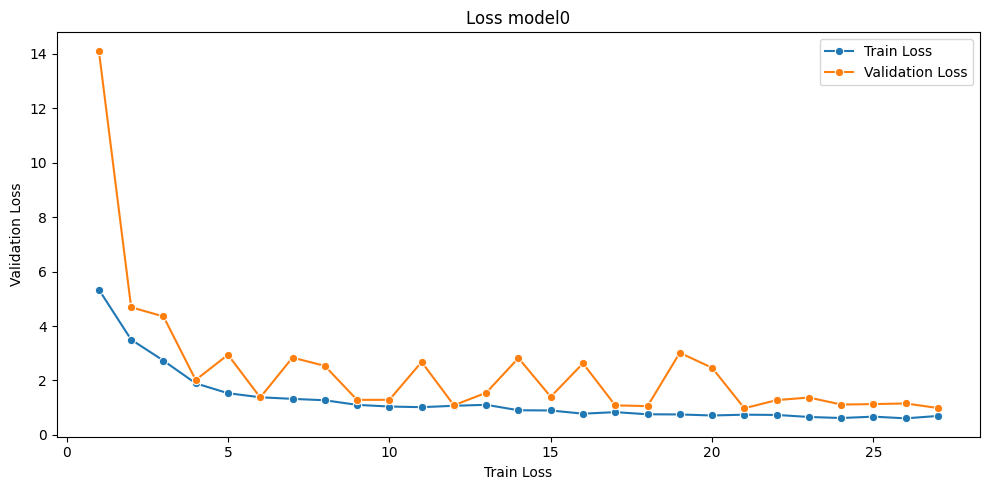

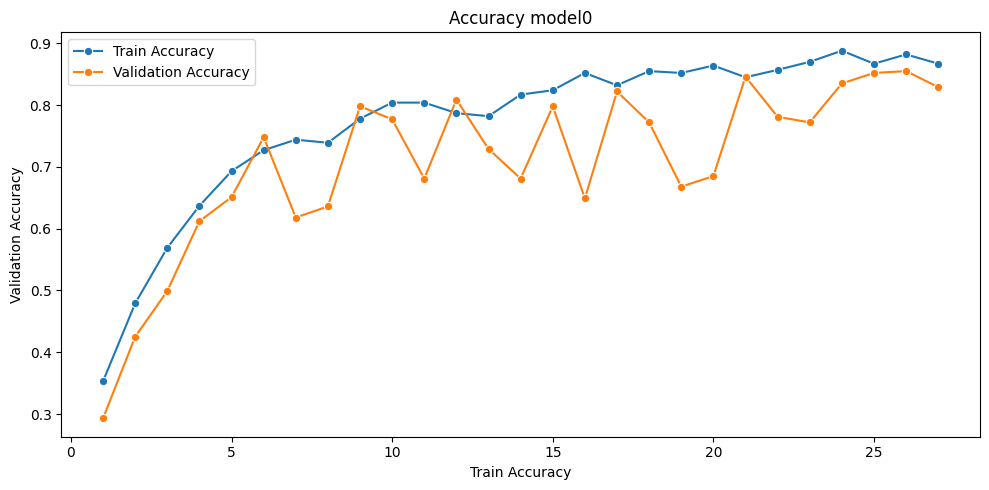

0.6116751269035533

In [14]:
K = 5
BALANCED = False
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

def compute_class_weights(data_stream):
    labels = [label for _, label in data_stream]
    label_counts = Counter(labels)
    total_samples = sum(label_counts.values())
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    max_label = max(label_counts.keys())
    weights_list = [class_weights.get(i, 0.0) for i in range(max_label + 1)]
    weights = torch.tensor(weights_list, dtype=torch.float)
    print(weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    weights = weights.to(device)
    return weights 


def compute_functions_criterion_weighted(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(weight=compute_class_weights(training_info)), optimizer, None

# Task 2 cu augmentari - cu functia de loss avand weights
compute_cross_validation(current_parameters, K, data_chunks, test_info, compute_train_transformations, compute_test_transformations, compute_functions_criterion_weighted)

In [43]:
from monai.transforms import Resize, Rand2DElastic, RandAdjustContrast, RandRotate, ScaleIntensity, Compose
from monai.transforms import RandGaussianNoise, RandAffine, RandStdShiftIntensity
from monai.transforms import RandGaussianSmooth, ThresholdIntensity, RandAxisFlip
from monai.transforms import RandSpatialCrop, RandGaussianSharpen, RandHistogramShift, RandShiftIntensity
import cv2

first_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    RandGaussianSharpen(),
    RandAxisFlip(prob=0.3),
    RandSpatialCrop(roi_size=SIZE, random_center=True, random_size=False),
    RandRotate(range_x=(-50, 50),  prob=0.5, keep_size=True),
    RandAdjustContrast(prob=0.8),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

second_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    Rand2DElastic(spacing=(5, 10), magnitude_range=(1, 2), prob=0.5, rotate_range=(0, 0), shear_range=(0.02, 0.02),
                    translate_range=(10, 10), scale_range=(0.1, 0.1), spatial_size=SIZE, mode="bilinear", padding_mode="reflection"),
    RandHistogramShift(prob=0.8),
    ThresholdIntensity(threshold=20),
    RandGaussianSmooth(sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), prob=0.8),
    RandRotate(range_x=(-50, 50),  prob=0.5, keep_size=True),
    ScaleIntensity(minv=0.0, maxv=1.0)
])


third_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    RandGaussianNoise(mean=0.0, std=0.1, prob=0.8),
    RandShiftIntensity(offsets=(-20, 20), prob=0.3, safe=True),
    RandAxisFlip(prob=0.3),
    RandStdShiftIntensity(factors=0.8),
    RandAffine(prob=0.2),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

test_augmentation_pipeline = Compose([
    Resize(spatial_size= SIZE),
    ScaleIntensity(minv=0.0, maxv=1.0)
])

def create_test_monai(img):
    img = np.transpose(img, (2, 0, 1))
    return test_augmentation_pipeline(img)

def create_first_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return first_augmentation_pipeline(img)


def create_second_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return second_augmentation_pipeline(img)


def create_third_monai_transform(img):
    img = np.transpose(img, (2, 0, 1))
    return third_augmentation_pipeline(img)

# img = torch.randint(low=0, high=255, size=(3, 400, 400))
# img = first_augmentation_pipeline(img)
# print(img.shape)

best model found at 0 loss is 4.728 accuracy is 0.389
best model found at 1 loss is 3.294 accuracy is 0.466
best model found at 2 loss is 2.508 accuracy is 0.534
best model found at 3 loss is 1.902 accuracy is 0.608
best model found at 4 loss is 1.88 accuracy is 0.657
best model found at 5 loss is 1.674 accuracy is 0.668
epoca 6 loss is 1.955 accuracy is 0.581
best model found at 7 loss is 1.347 accuracy is 0.713
epoca 8 loss is 1.373 accuracy is 0.711
best model found at 9 loss is 1.424 accuracy is 0.749
best model found at 10 loss is 1.173 accuracy is 0.775
epoca 11 loss is 1.525 accuracy is 0.723
epoca 12 loss is 1.303 accuracy is 0.751
epoca 13 loss is 1.137 accuracy is 0.772
best model found at 14 loss is 1.161 accuracy is 0.792
epoca 15 loss is 1.272 accuracy is 0.742
best model found at 16 loss is 0.957 accuracy is 0.815
best model found at 17 loss is 1.033 accuracy is 0.819
best model found at 18 loss is 0.687 accuracy is 0.849
epoca 19 loss is 0.81 accuracy is 0.842
best model

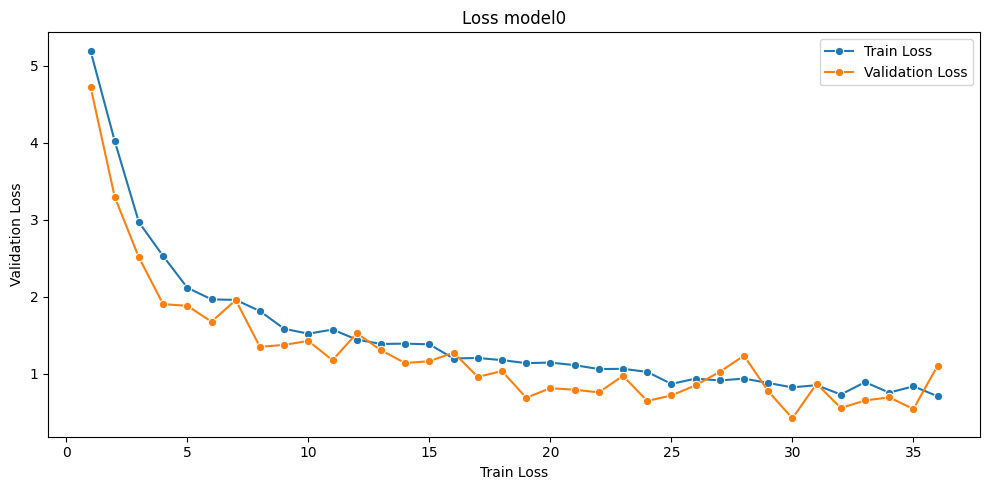

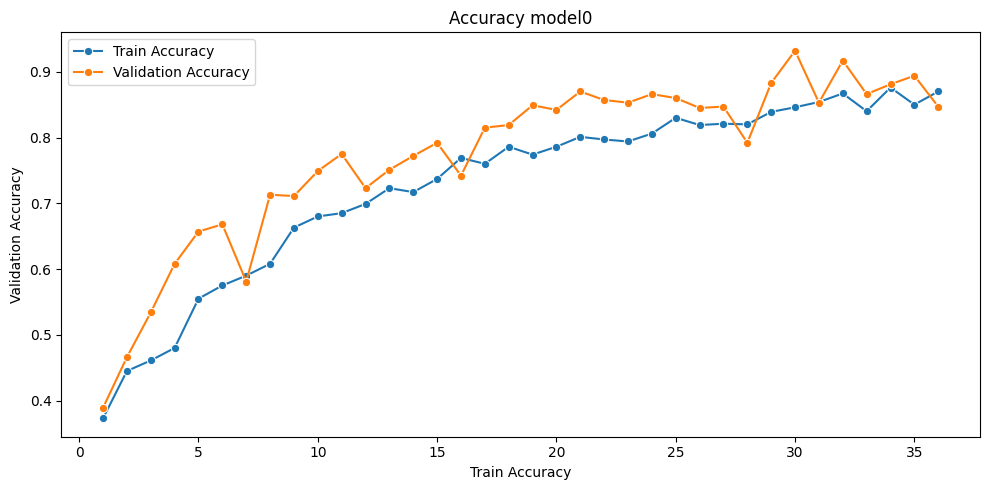

0.6979695431472082

In [41]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)
compute_cross_validation(current_parameters, K, data_chunks, test_info, create_first_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)

best model found at 0 loss is 5.827 accuracy is 0.24
best model found at 1 loss is 3.485 accuracy is 0.432
best model found at 2 loss is 2.252 accuracy is 0.536
best model found at 3 loss is 2.078 accuracy is 0.592
best model found at 4 loss is 1.906 accuracy is 0.649
epoca 5 loss is 1.638 accuracy is 0.638
best model found at 6 loss is 1.604 accuracy is 0.666
best model found at 7 loss is 1.674 accuracy is 0.687
epoca 8 loss is 1.64 accuracy is 0.651
best model found at 9 loss is 1.208 accuracy is 0.766
epoca 10 loss is 1.6 accuracy is 0.719
epoca 11 loss is 1.244 accuracy is 0.725
epoca 12 loss is 1.462 accuracy is 0.681
best model found at 13 loss is 0.979 accuracy is 0.825
epoca 14 loss is 1.563 accuracy is 0.721
epoca 15 loss is 1.192 accuracy is 0.755
epoca 16 loss is 1.102 accuracy is 0.796
epoca 17 loss is 1.32 accuracy is 0.745
epoca 18 loss is 1.163 accuracy is 0.753
epoca 19 loss is 1.292 accuracy is 0.774
Loss-ul nu a scazut de ceva vreme, a intervenit early stopping


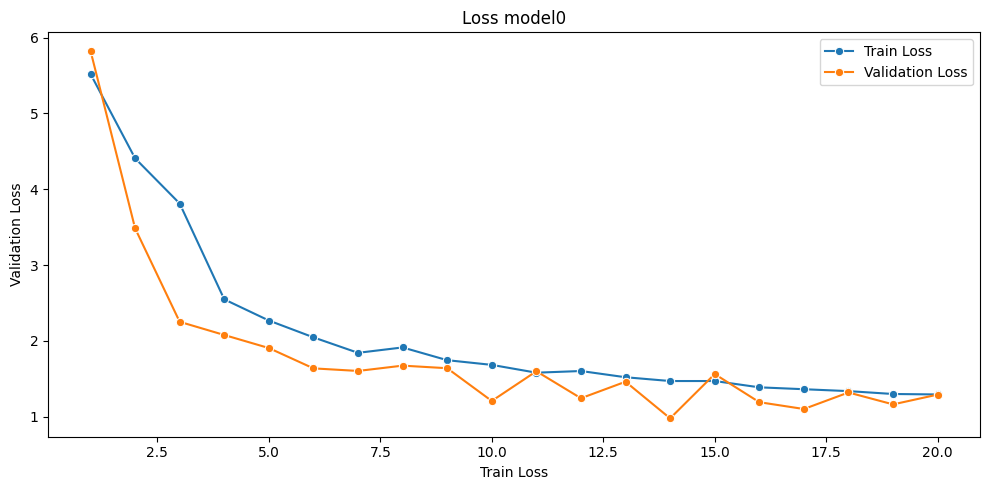

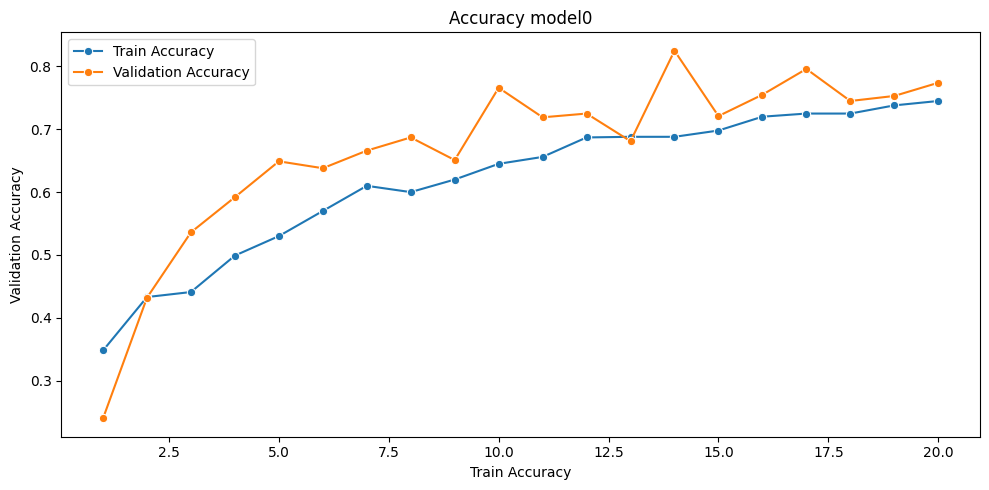

0.5634517766497462

In [44]:
compute_cross_validation(current_parameters, K, data_chunks, test_info, create_second_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)

best model found at 0 loss is 3.349 accuracy is 0.594
best model found at 1 loss is 3.81 accuracy is 0.726
epoca 2 loss is 1.797 accuracy is 0.708
best model found at 3 loss is 1.426 accuracy is 0.808
best model found at 4 loss is 1.194 accuracy is 0.813
epoca 5 loss is 1.343 accuracy is 0.806
best model found at 6 loss is 0.775 accuracy is 0.889
epoca 7 loss is 2.343 accuracy is 0.77
epoca 8 loss is 0.737 accuracy is 0.889
epoca 9 loss is 3.918 accuracy is 0.725
epoca 10 loss is 0.777 accuracy is 0.887
best model found at 11 loss is 0.601 accuracy is 0.925
epoca 12 loss is 0.928 accuracy is 0.858
epoca 13 loss is 1.216 accuracy is 0.864
epoca 14 loss is 0.792 accuracy is 0.889
epoca 15 loss is 1.932 accuracy is 0.809
best model found at 16 loss is 0.56 accuracy is 0.93
epoca 17 loss is 0.644 accuracy is 0.911
epoca 18 loss is 1.558 accuracy is 0.828
epoca 19 loss is 1.007 accuracy is 0.875
epoca 20 loss is 3.223 accuracy is 0.76
epoca 21 loss is 1.267 accuracy is 0.868
epoca 22 loss i

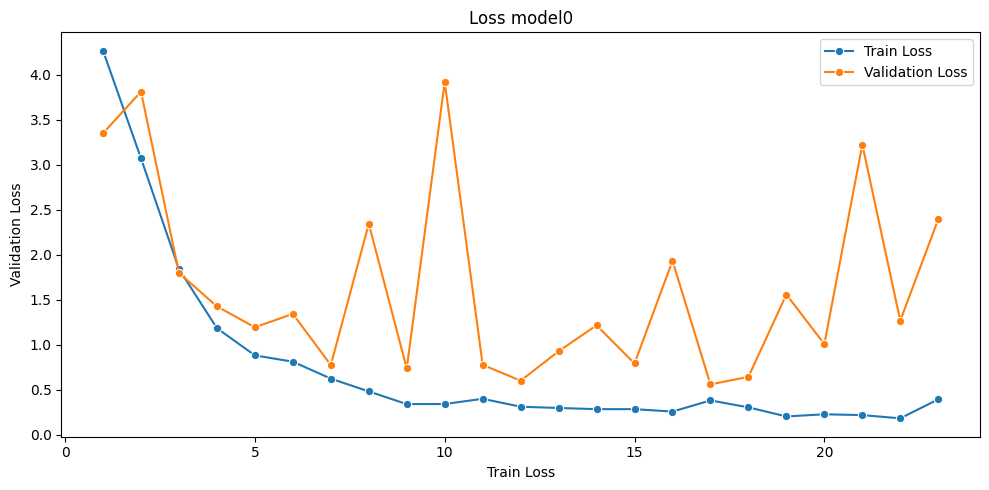

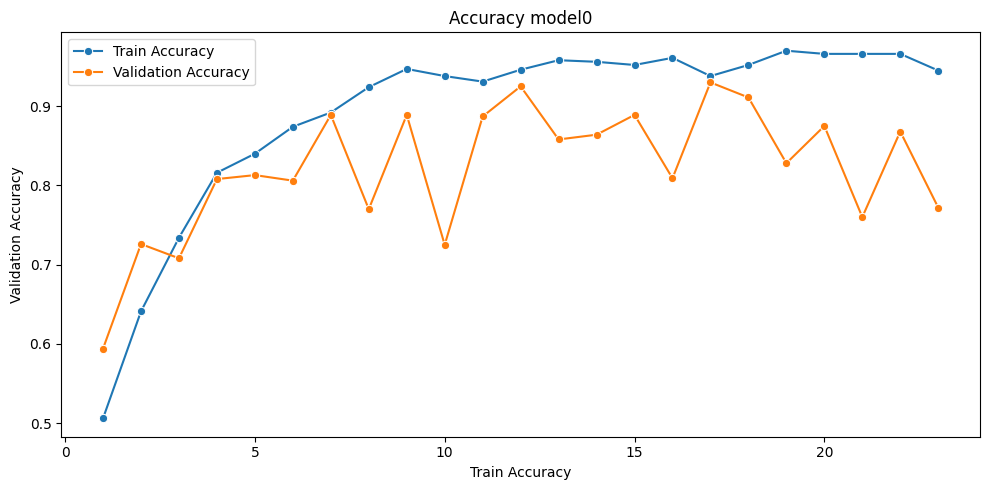

0.700507614213198

In [45]:
compute_cross_validation(current_parameters, K, data_chunks, test_info, create_third_monai_transform, create_test_monai, compute_functions_balanced_no_scheduler)

In [ ]:
def compute_functions_simple(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"])